In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Tuple
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

In [2]:
device = torch.device('cuda')

data = pd.read_csv("./cpu_mem/gc19_a.csv")
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
print(data.dtypes)
print(data)

Unnamed: 0      int64
avgcpu        float64
avgmem        float64
dtype: object
                         Unnamed: 0    avgcpu    avgmem
time                                                   
1970-01-19 00:24:29.400           0  0.382435  0.547465
1970-01-19 00:24:29.700           1  0.378298  0.519147
1970-01-19 00:24:30.000           2  0.483908  0.558514
1970-01-19 00:24:30.300           3  0.552523  0.597547
1970-01-19 00:24:30.600           4  0.576535  0.632134
...                             ...       ...       ...
1970-01-19 01:06:13.500        8347  0.514038  0.436060
1970-01-19 01:06:13.800        8348  0.540209  0.458608
1970-01-19 01:06:14.100        8349  0.511666  0.416801
1970-01-19 01:06:14.400        8350  0.484233  0.383571
1970-01-19 01:06:14.700        8351  0.507469  0.390416

[8352 rows x 3 columns]


In [3]:
history_size = 96
predict_size = 96
hidden_size = 256
batch = 64
n_layers = 4
n_epoch = 500
lr = 0.0005

train_split = predict_size * batch

In [4]:
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

In [5]:
class LSTMCell(nn.Module):
    def __init__(self, input_size : int, hidden_size : int):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_lin = nn.Linear(hidden_size, 4 * hidden_size)
        self.input_lin = nn.Linear(input_size, 4 * hidden_size, bias=False)

    def forward(self, x, h_in, c_in):
        X = self.input_lin(x) + self.hidden_lin(h_in) # 입력과 은닉 상태를 선형 변환 후 더함
        i, f, g, o = X.chunk(4, dim=-1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)

        c_next = c_in * f + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next
    
class MY_LSTM(nn.Module):
    def __init__(self, input_size: int, predict_size: int, hidden_size: int, n_layers: int, use_RevIN: bool):
        super(MY_LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.use_Revin = use_RevIN
        self.cells = nn.ModuleList(
            [LSTMCell(input_size=input_size, hidden_size=hidden_size)] +
            [LSTMCell(input_size=hidden_size, hidden_size=hidden_size) for _ in range(n_layers - 1)]
        )
        self.linear = nn.Linear(self.hidden_size, 1)
        self.revin = RevIN(1)

    def forward(self, x: torch.Tensor, state: Optional[Tuple[torch.Tensor, torch.Tensor]] = None):
        batch_size, seq_len, _ = x.shape
        if self.use_Revin:
            x = self.revin(x, "norm")

        if state is None:
            h = [x.new_zeros(batch_size, self.hidden_size) for _ in range(self.n_layers)]
            c = [x.new_zeros(batch_size, self.hidden_size) for _ in range(self.n_layers)]
        else:
            h, c = state
            h, c = list(torch.unbind(h)), list(torch.unbind(c))

        outputs = []  # 각 time step의 출력을 담는 리스트
        for t in range(batch_size):
            inp = x[t, :].squeeze(-1)  # 각 시점의 입력
            for layer in range(self.n_layers):
                h[layer], c[layer] = self.cells[layer](inp, h[layer], c[layer])
                inp = h[layer]
            outputs.append(self.linear(h[-1]))  # 각 time step에서 마지막 layer의 hidden state를 사용해 예측
        
        outputs = torch.stack(outputs, dim=0).squeeze(1)  # 모든 time step의 예측을 쌓음

        if self.use_Revin:
            outputs = self.revin(outputs, "denorm").squeeze(1)

        h = torch.stack(h)
        c = torch.stack(c)

        return outputs, (h, c)


In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size, single_step=False):
    datas = []
    labels = []

    start_index = start_index + history_size

    if end_index == None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        datas.append(np.reshape(dataset[indices], (history_size,1)))

        if single_step: # 단기 예측
            labels.append(dataset[i]) # start_index + history_size + target_size
        else: # 장기 예측
            labels.append(dataset[i:i + target_size]) # i ~ i + target_size - 1

    return np.array(datas), np.array(labels)

def multivariate_data(dataset, start_index, end_index, history_size, target_size, step, single_step=False):
    datas = []
    labels = []

    start_index = start_index + history_size

    if end_index == None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        datas.append(dataset[indices])

        if single_step: # 단기 예측
            labels.append(dataset[i + target_size])
        else: # 장기 예측
            labels.append(dataset[i:i + target_size])
    return np.array(datas), np.array(labels)

def create_time_steps(length):
    if length >= 0:
        return range(0, length)
    else:
        return range(length + 1, 1)

def show_plot(plot_data, delta, title):
    labels = ["history", "true future", "baseline", "mean"]
    marker = ["-", "r-", "g-", "yx"]
    time_steps = create_time_steps(-plot_data[0].shape[0])

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i == 3:
            plt.plot(1, plot_data[i], marker[i], label=labels[i])
        elif i:
            plt.plot(create_time_steps(x.shape[0]), plot_data[i], marker[i], label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    plt.axis('auto')
    plt.xlabel('time-steps')
    plt.show()
    return plt  

/tmp/ipykernel_2815932/1859699327.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  datas.append(np.reshape(dataset[indices], (history_size,1)))
/tmp/ipykernel_2815932/1859699327.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(dataset[i]) # start_index + history_size + target_size


torch.Size([64, 96, 1]) torch.Size([64])


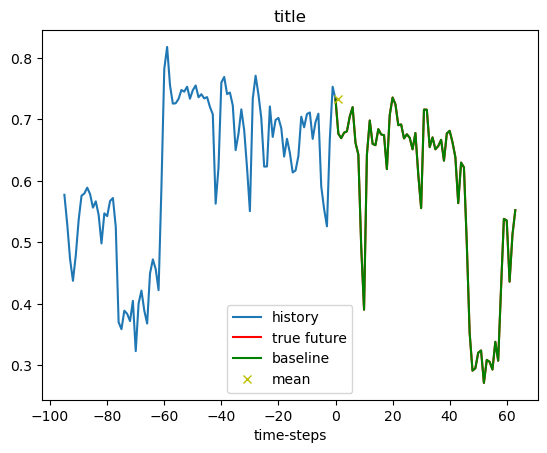

<module 'matplotlib.pyplot' from '/home/icns/anaconda3/envs/mincheol/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [7]:
x_train_uni, y_train_uni = univariate_data(data['avgcpu'], 0, train_split, history_size, predict_size, True)
x_test_uni, y_test_uni = univariate_data(data['avgcpu'], train_split, None, history_size, predict_size, True)

x_train_uni = torch.FloatTensor(x_train_uni).to(device)
y_train_uni = torch.FloatTensor(y_train_uni).to(device)
x_test_uni = torch.FloatTensor(x_test_uni).to(device)
y_test_uni = torch.FloatTensor(y_test_uni).to(device)

dataset = TensorDataset(x_train_uni, y_train_uni)
dataloader = DataLoader(dataset, batch_size=batch)

test_dataset = TensorDataset(x_test_uni, y_test_uni)
test_dataloader = DataLoader(test_dataset, batch_size=batch)

train, test = next(iter(test_dataloader))
print(train.shape, test.shape)

# data_len = histroy size
show_plot([train[1].squeeze(-1).cpu(), test.cpu(), test.cpu(), test[0].cpu()], 0, "title")

In [8]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()
        self.mse = nn.MSELoss()
        self.eps = 1e-7

    def forward(self,y,y_hat):
        return torch.sqrt(self.mse(y,y_hat) + self.eps)

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, n_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = n_layers
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, num_classes) # 입력 : hidden_size, 출력 : num_classes

    def forward(self, x):
        hidden_states = torch.zeros(self.num_layers, x.shape[0], self.hidden_size) # hidden_layer 개수, sample 개수, hidden_layer 크기
        cell_states = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        out, (h, c) = self.lstm(x, (hidden_states, cell_states)) # input : x, 초기 상태 : (hidden_states, cell_states), out : 모든 time step(sequence)의 출력, _ : 은닉 상태 및 셀 상태
        out = self.output_layer(out) # 각 입력 시퀀스에 대해 마지막 time step의 출력
        return out, (h, c)

In [10]:
model1 = LSTM(input_size=1, hidden_size=hidden_size, n_layers=n_layers, num_classes=1).to(device)
model2 = MY_LSTM(input_size=history_size, predict_size=predict_size, hidden_size=hidden_size, n_layers=n_layers, use_RevIN=False).to(device)
optimizer = optim.Adam(model2.parameters(), lr)

In [11]:
import time

def train_model(model, train_df, num_epochs = 5, lr = 0.001, verbose = 2, patience = 10):
    model.train()
     
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr)
    
    # epoch마다 loss 저장
    train_hist = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        start = time.time()
        for batch_idx, samples in enumerate(train_df):
            # seq별 hidden state reset
            h, c = None, None
            
            x_train, y_train = samples
            x_train.squeeze(0)

            # H(x) 계산
            # outputs, _ = model(x_train)
            if h is not None and c is not None:
                h = h.detach()
                c = c.detach()
                
            # 모델 예측
            outputs, _ = model(x_train) if h is not None and c is not None else model(x_train)
                
            # cost 계산
            loss = criterion(outputs[:, -1, :], y_train)   
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost), f'time: {time.time() - start}')
            show_plot([x_train[1].squeeze(-1).cpu(), y_train.cpu(), outputs[:, -1, :].detach().cpu().numpy()], 0, "title")
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

0 95


/home/icns/anaconda3/envs/mincheol/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/icns/anaconda3/envs/mincheol/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0000 train loss : 0.0344 time: 15.62583613395691


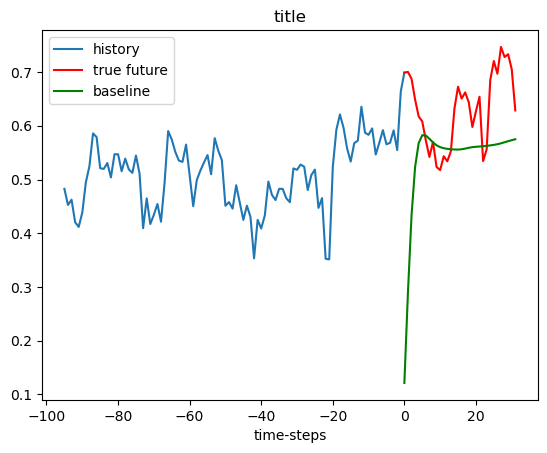

1 95
Epoch: 0001 train loss : 0.0208 time: 15.579501867294312


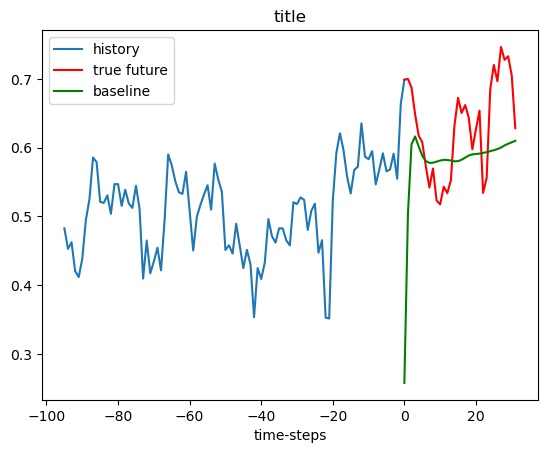

2 95
Epoch: 0002 train loss : 0.0165 time: 14.789297580718994


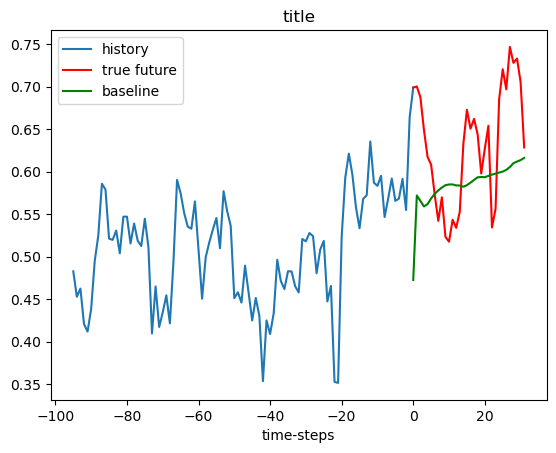

3 95
Epoch: 0003 train loss : 0.0150 time: 13.500734090805054


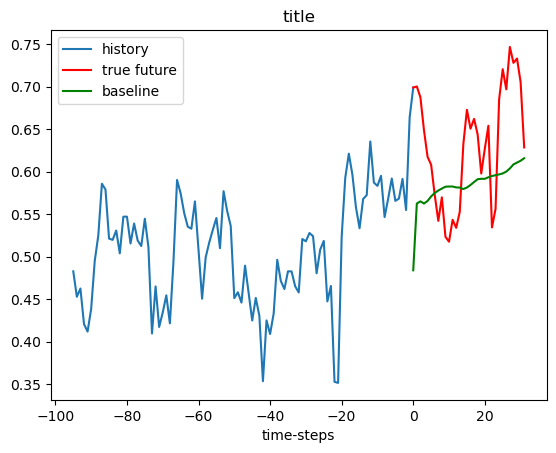

4 95
Epoch: 0004 train loss : 0.0146 time: 13.585861444473267


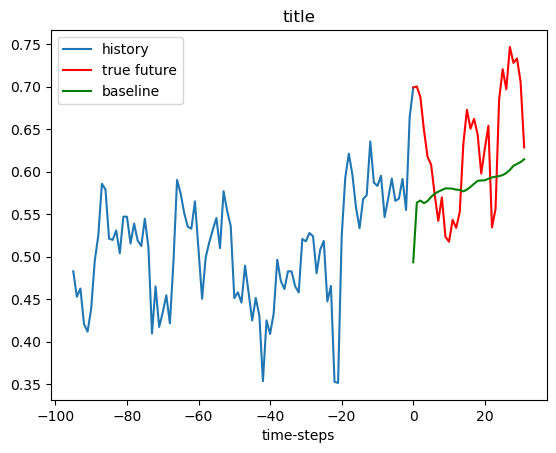

5 95
Epoch: 0005 train loss : 0.0144 time: 13.477007865905762


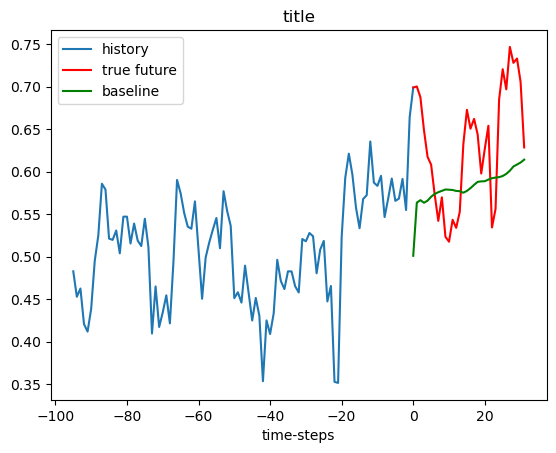

6 95
Epoch: 0006 train loss : 0.0142 time: 13.470726251602173


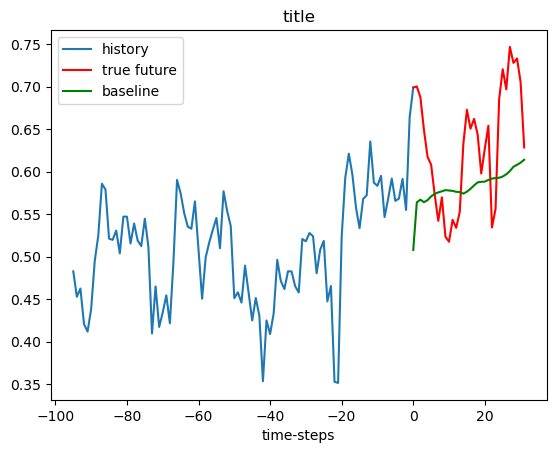

7 95
Epoch: 0007 train loss : 0.0141 time: 15.560811281204224


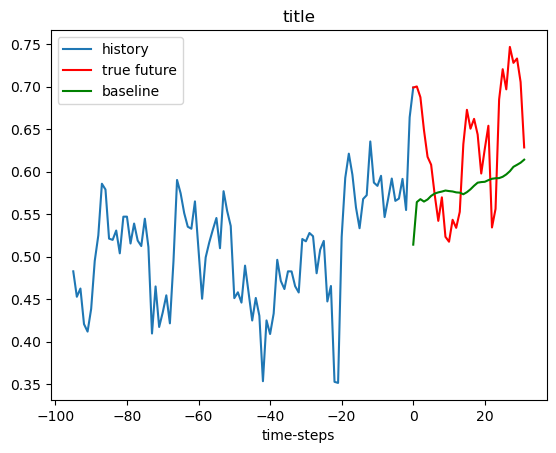

8 95
Epoch: 0008 train loss : 0.0140 time: 17.352370023727417


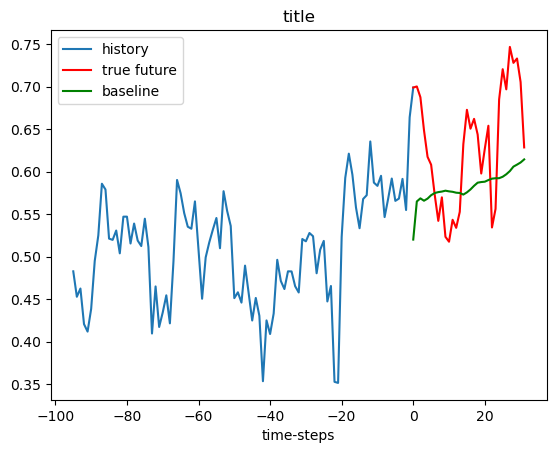

9 95
Epoch: 0009 train loss : 0.0139 time: 16.542983770370483


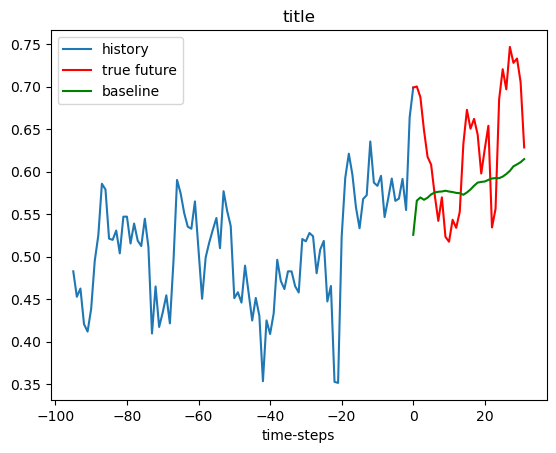

10 95
Epoch: 0010 train loss : 0.0138 time: 17.000139474868774


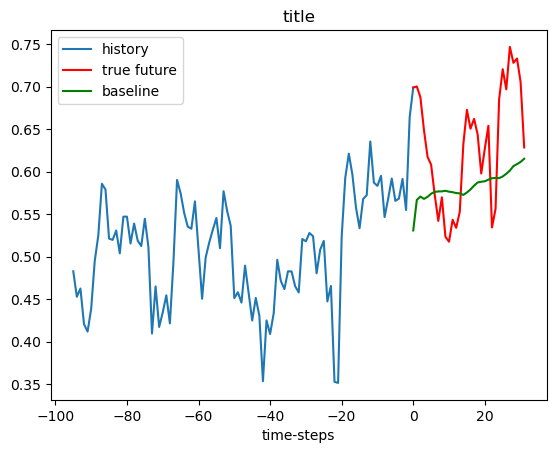

11 95
Epoch: 0011 train loss : 0.0137 time: 17.0188410282135


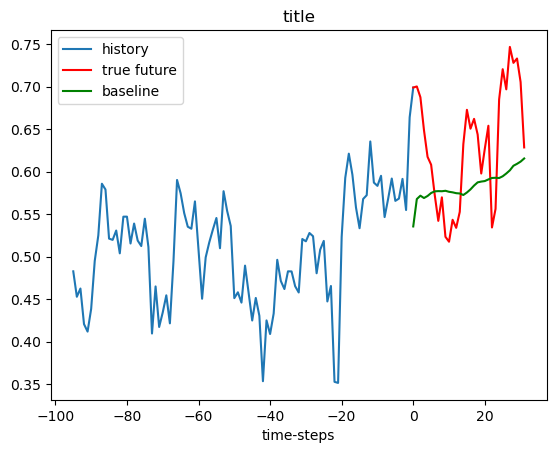

12 95
Epoch: 0012 train loss : 0.0137 time: 16.9725022315979


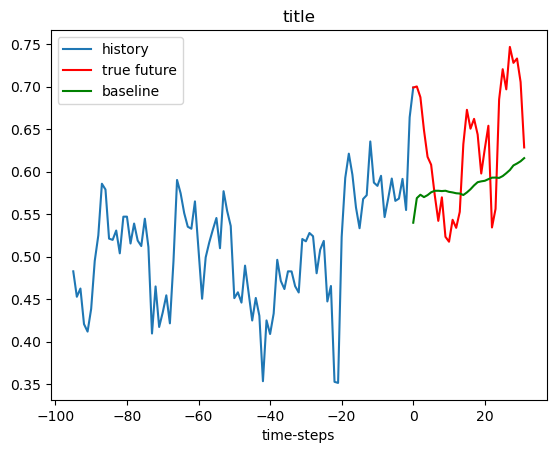

13 95
Epoch: 0013 train loss : 0.0136 time: 16.838852882385254


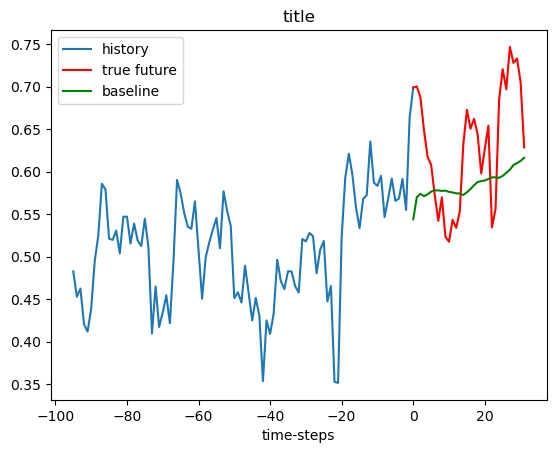

14 95
Epoch: 0014 train loss : 0.0136 time: 17.082707166671753


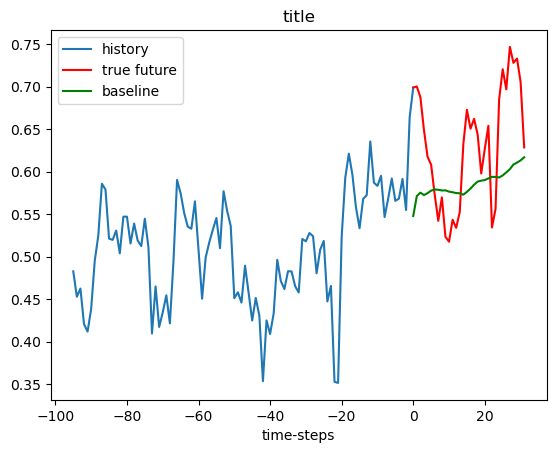

15 95
Epoch: 0015 train loss : 0.0135 time: 16.807697296142578


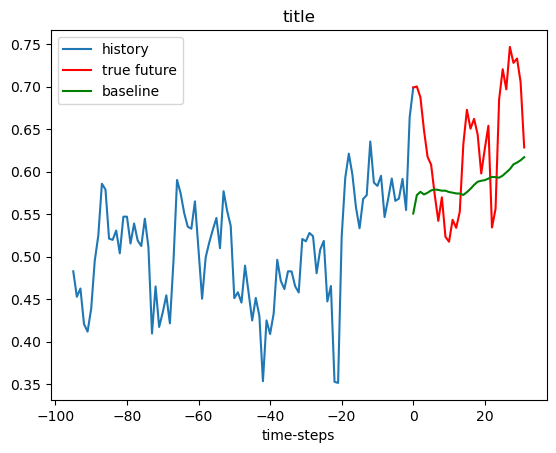

16 95
Epoch: 0016 train loss : 0.0135 time: 16.70638680458069


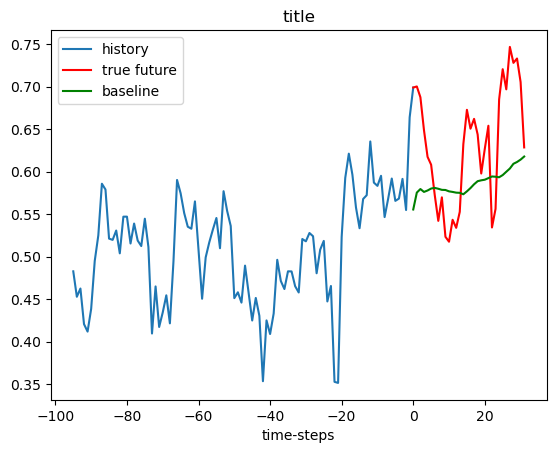

17 95
Epoch: 0017 train loss : 0.0134 time: 16.891478538513184


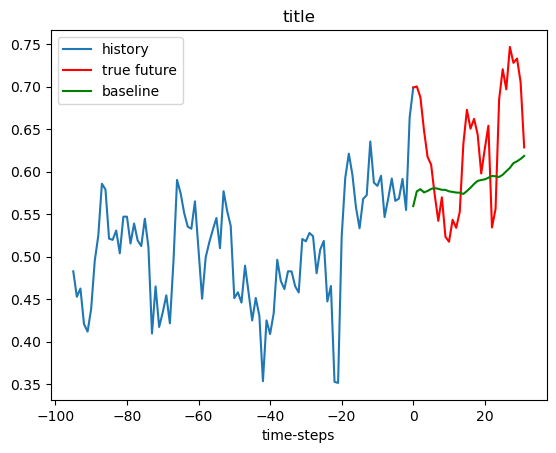

18 95
Epoch: 0018 train loss : 0.0133 time: 16.695274114608765


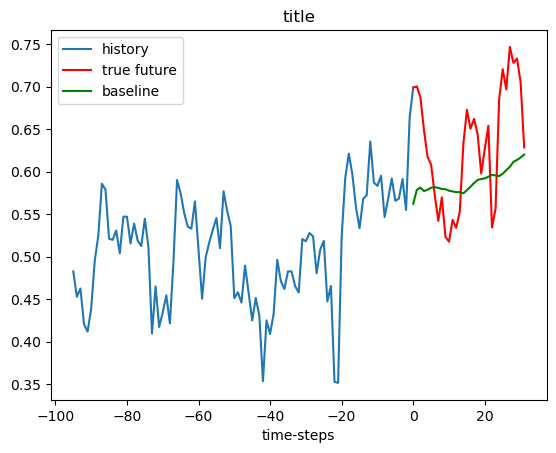

19 95
Epoch: 0019 train loss : 0.0132 time: 13.424124240875244


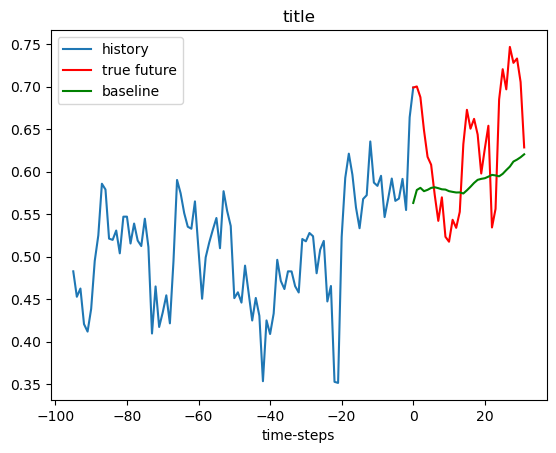

20 95
Epoch: 0020 train loss : 0.0131 time: 13.780986070632935


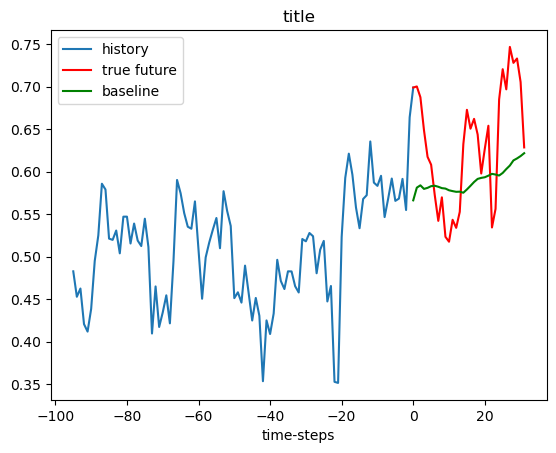

21 95
Epoch: 0021 train loss : 0.0130 time: 13.59897494316101


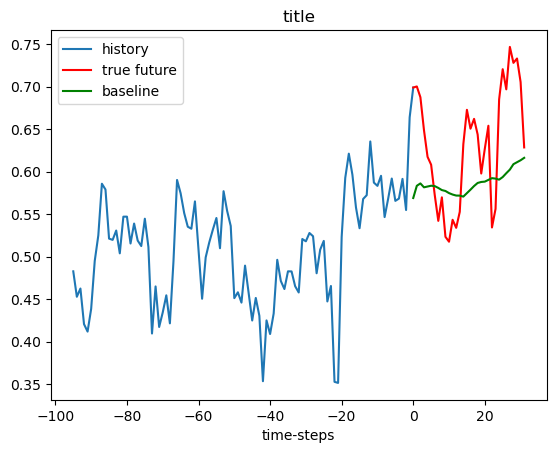

22 95
Epoch: 0022 train loss : 0.0128 time: 13.340997219085693


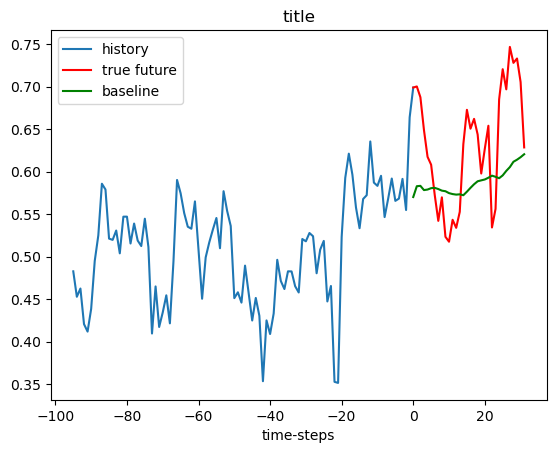

23 95
Epoch: 0023 train loss : 0.0125 time: 13.374159097671509


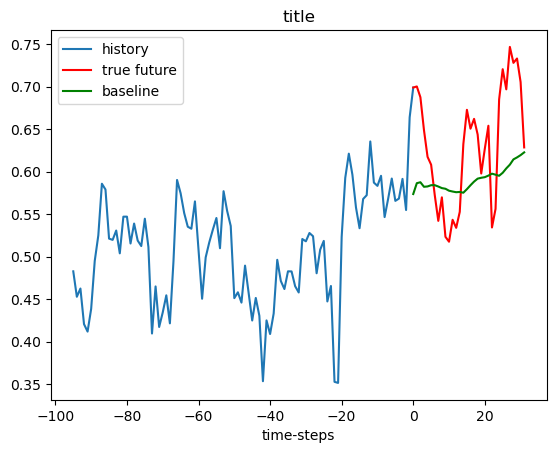

24 95
Epoch: 0024 train loss : 0.0129 time: 13.254912853240967


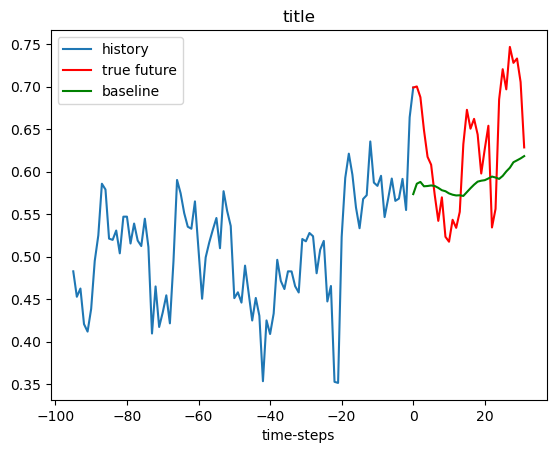

25 95
Epoch: 0025 train loss : 0.0125 time: 13.571431398391724


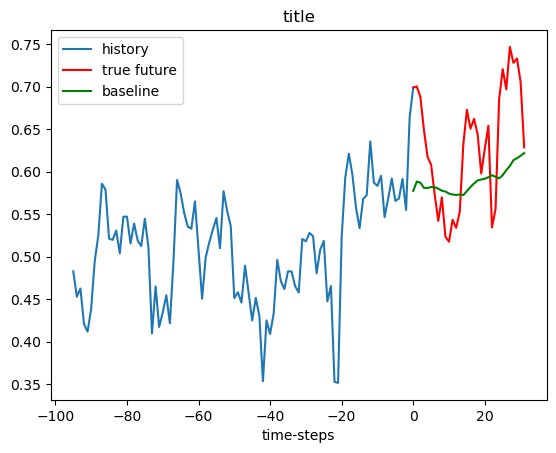

26 95
Epoch: 0026 train loss : 0.0123 time: 13.22404408454895


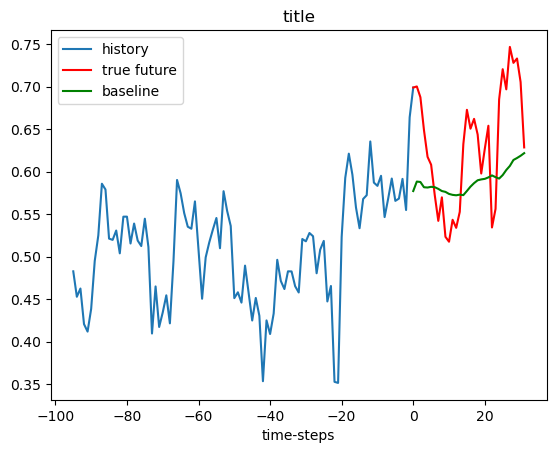

27 95
Epoch: 0027 train loss : 0.0124 time: 13.435408592224121


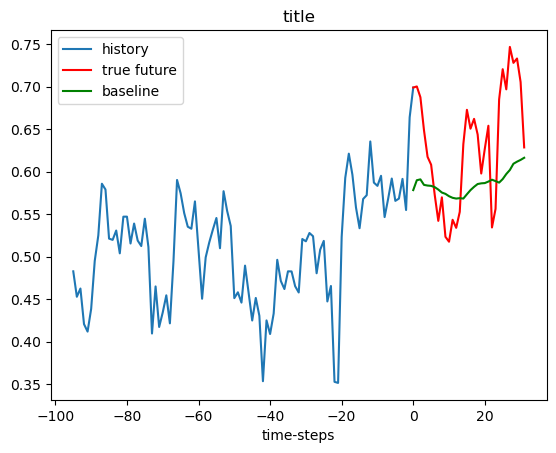

28 95
Epoch: 0028 train loss : 0.0123 time: 13.334540605545044


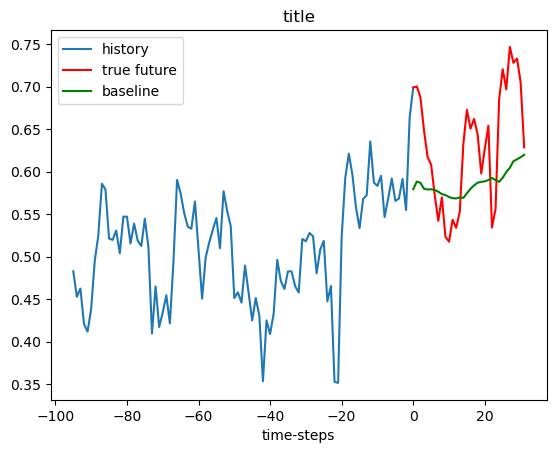

29 95
Epoch: 0029 train loss : 0.0121 time: 13.412693977355957


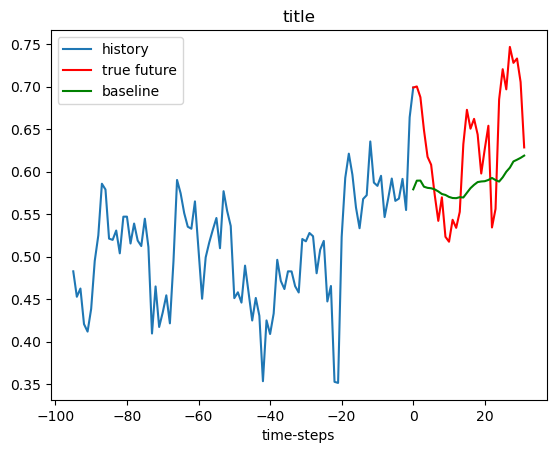

30 95
Epoch: 0030 train loss : 0.0124 time: 13.342844247817993


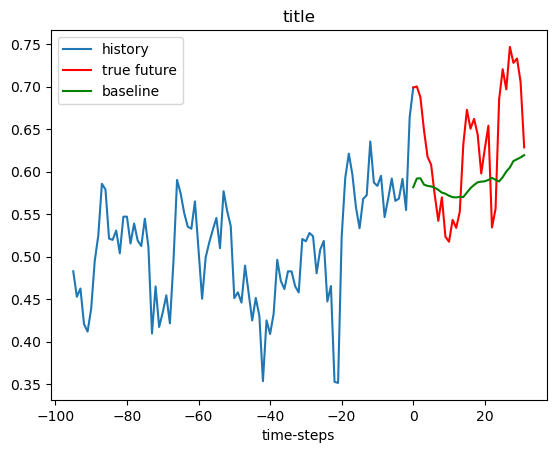

31 95
Epoch: 0031 train loss : 0.0122 time: 13.527345418930054


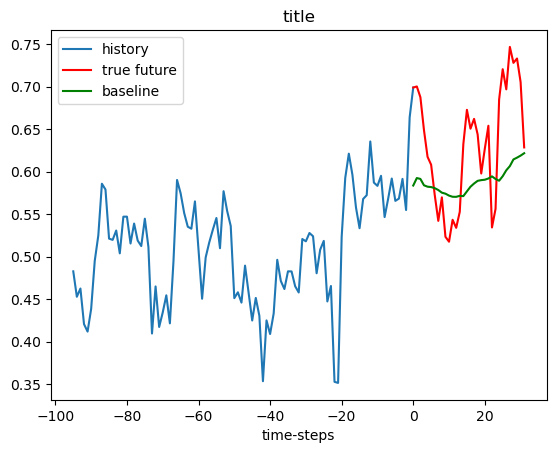

32 95
Epoch: 0032 train loss : 0.0121 time: 13.3392813205719


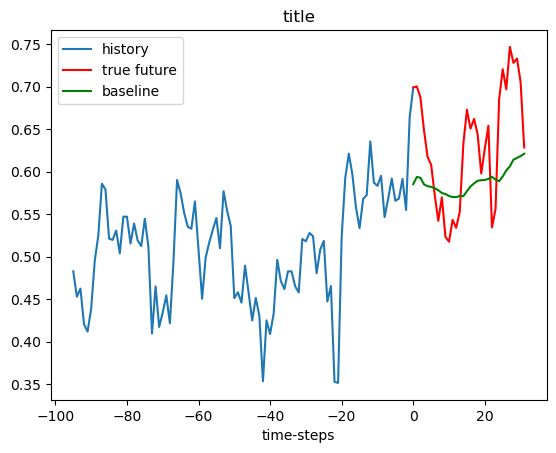

33 95
Epoch: 0033 train loss : 0.0123 time: 15.65025520324707


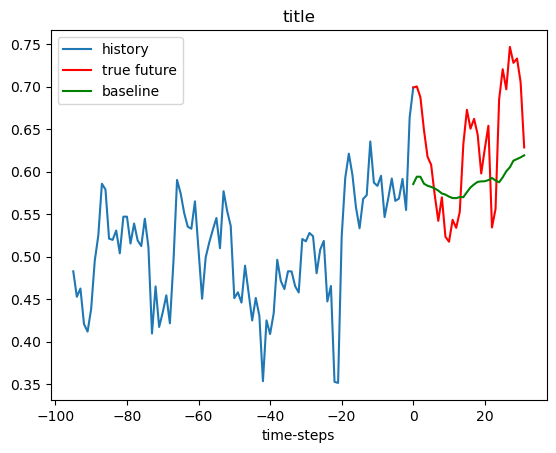

34 95
Epoch: 0034 train loss : 0.0121 time: 18.06017231941223


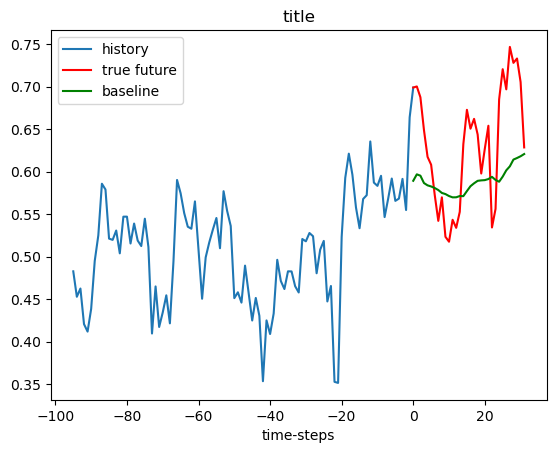

35 95
Epoch: 0035 train loss : 0.0121 time: 14.539140224456787


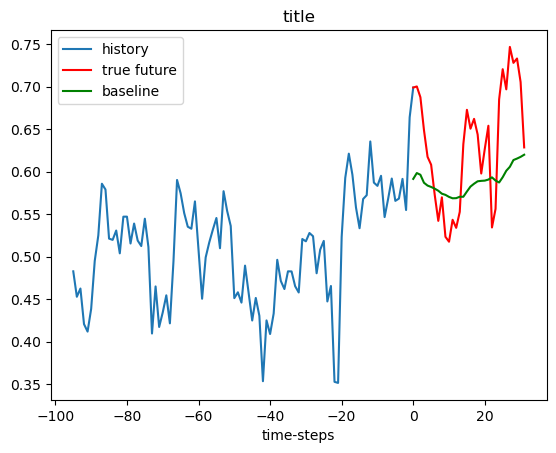

36 95
Epoch: 0036 train loss : 0.0121 time: 13.18371844291687


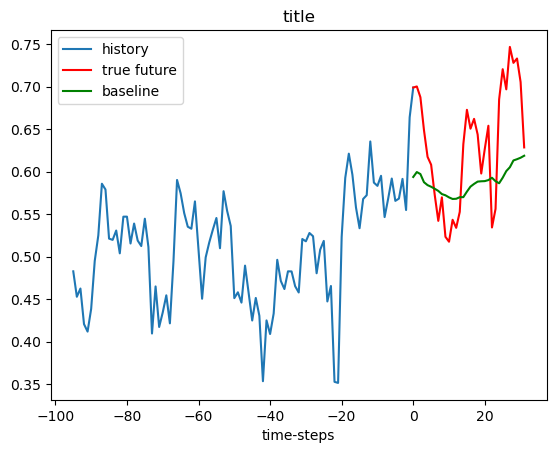

37 95
Epoch: 0037 train loss : 0.0120 time: 13.215008020401001


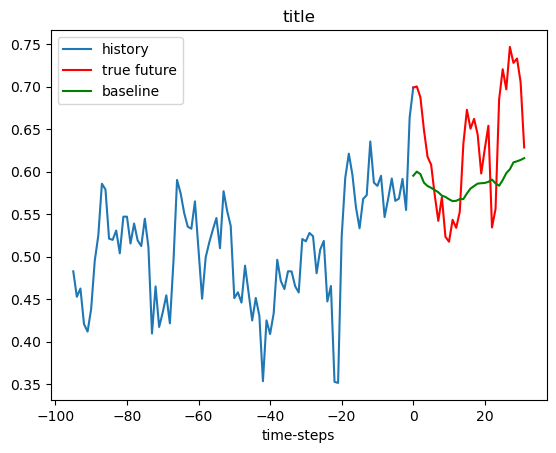

38 95
Epoch: 0038 train loss : 0.0120 time: 13.240288972854614


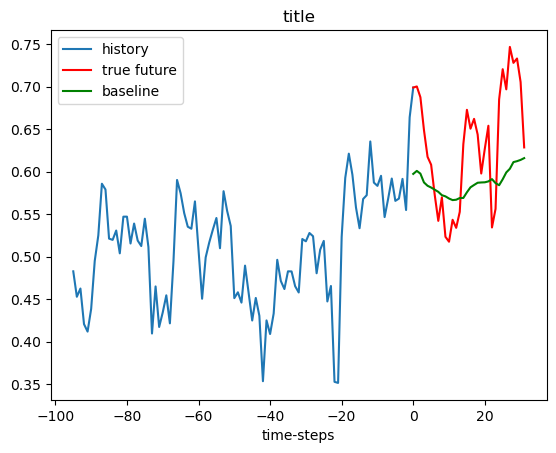

39 95
Epoch: 0039 train loss : 0.0122 time: 13.267242193222046


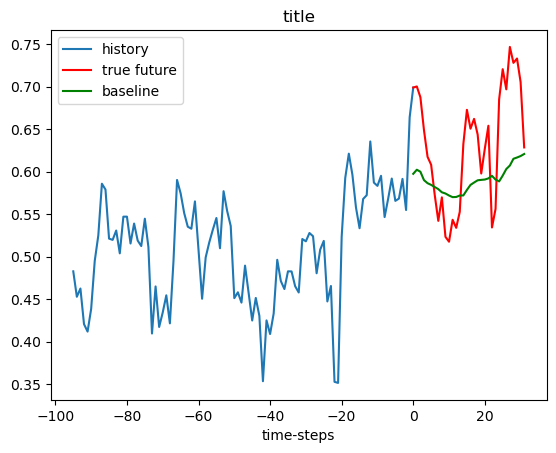

40 95
Epoch: 0040 train loss : 0.0120 time: 13.440575361251831


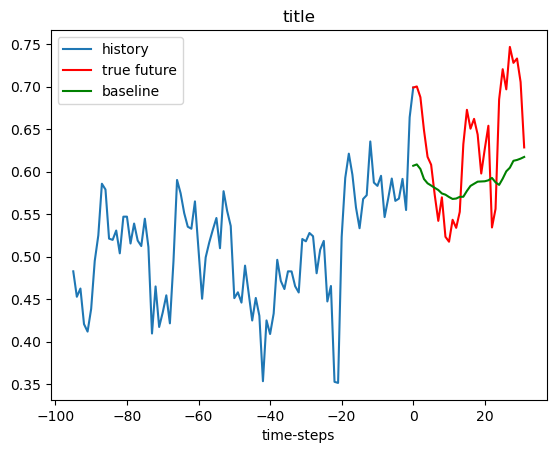

41 95
Epoch: 0041 train loss : 0.0120 time: 13.102283716201782


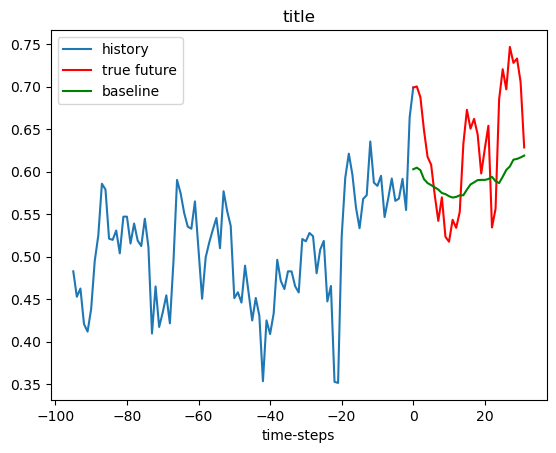

42 95
Epoch: 0042 train loss : 0.0122 time: 13.259450197219849


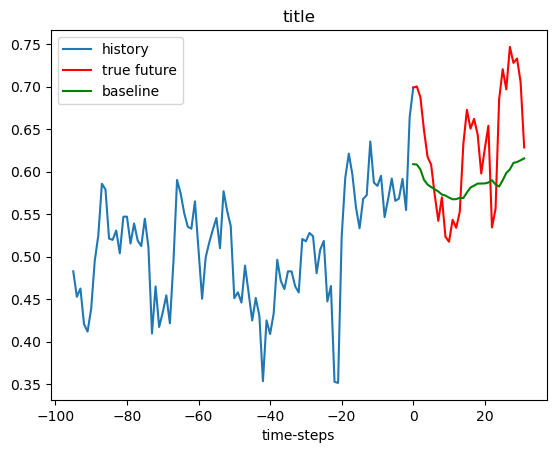

43 95
Epoch: 0043 train loss : 0.0119 time: 13.197391271591187


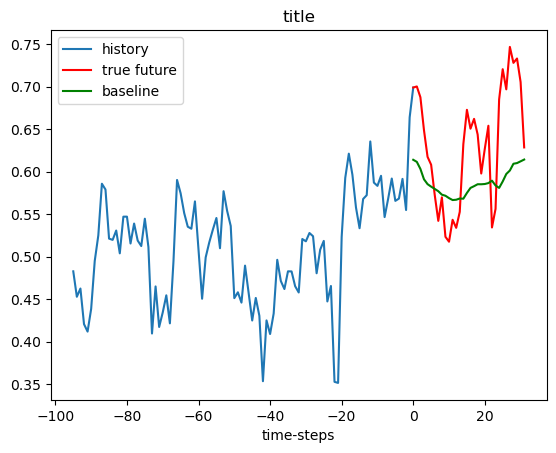

44 95
Epoch: 0044 train loss : 0.0119 time: 13.452229022979736


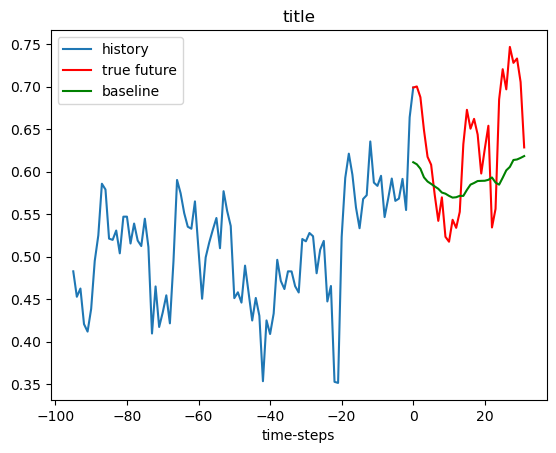

45 95
Epoch: 0045 train loss : 0.0121 time: 13.26636552810669


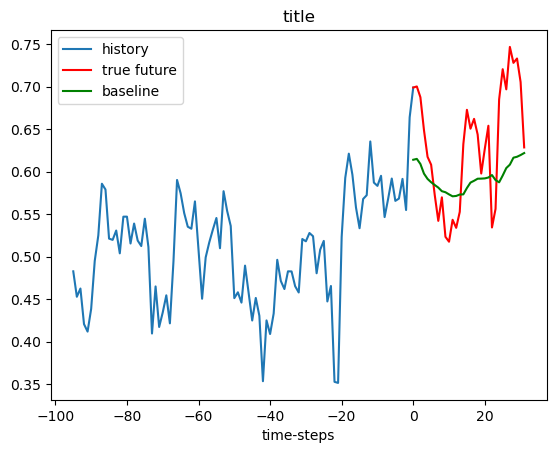

46 95
Epoch: 0046 train loss : 0.0118 time: 13.409226655960083


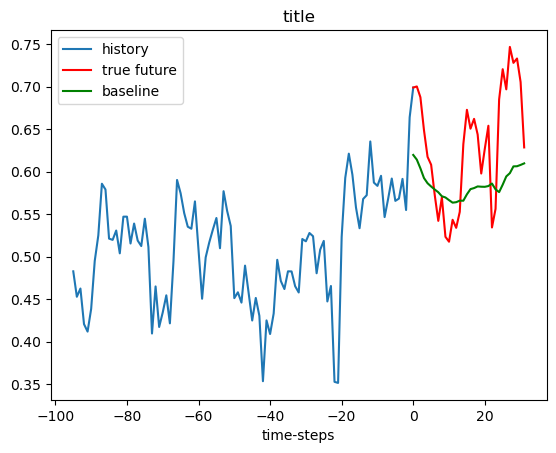

47 95
Epoch: 0047 train loss : 0.0118 time: 13.147935390472412


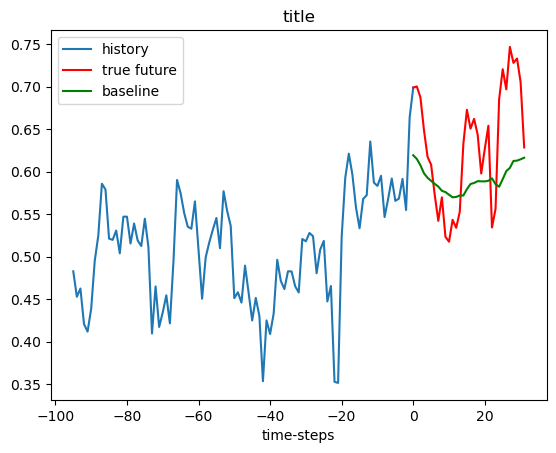

48 95
Epoch: 0048 train loss : 0.0118 time: 13.38865327835083


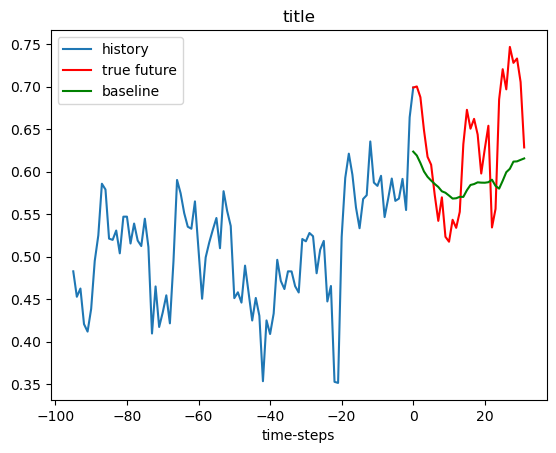

49 95
Epoch: 0049 train loss : 0.0118 time: 13.277208089828491


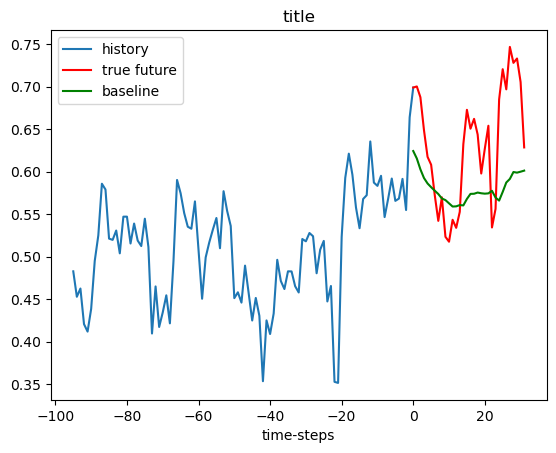

50 95
Epoch: 0050 train loss : 0.0117 time: 13.476832866668701


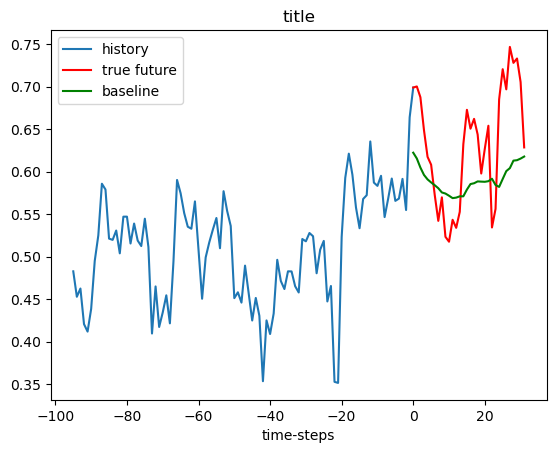

51 95
Epoch: 0051 train loss : 0.0118 time: 13.197113037109375


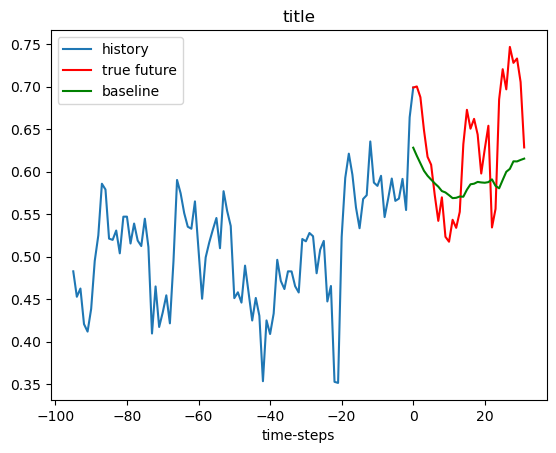

52 95
Epoch: 0052 train loss : 0.0117 time: 13.381312608718872


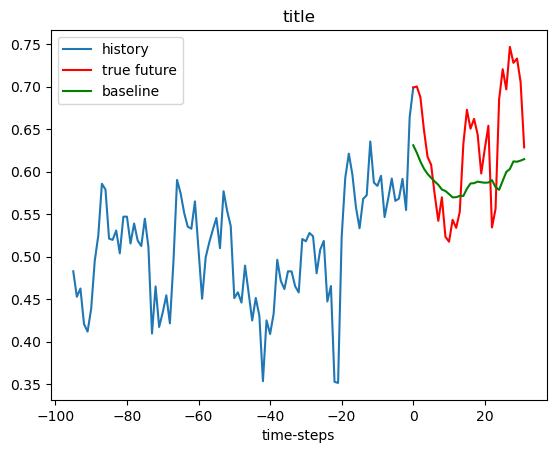

53 95
Epoch: 0053 train loss : 0.0117 time: 13.355489492416382


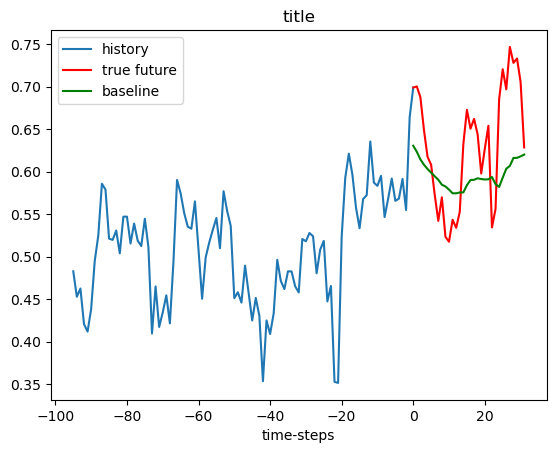

54 95
Epoch: 0054 train loss : 0.0118 time: 13.474400043487549


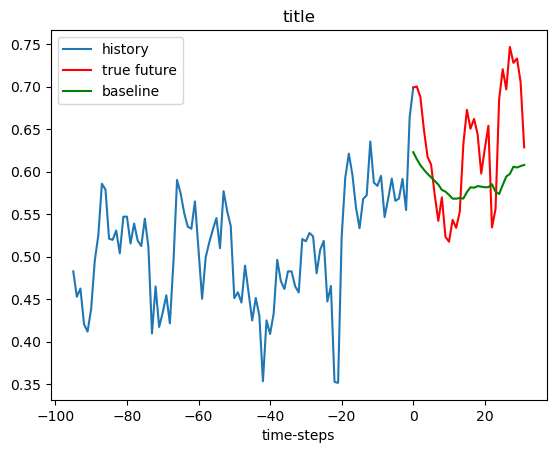

55 95
Epoch: 0055 train loss : 0.0118 time: 13.3193678855896


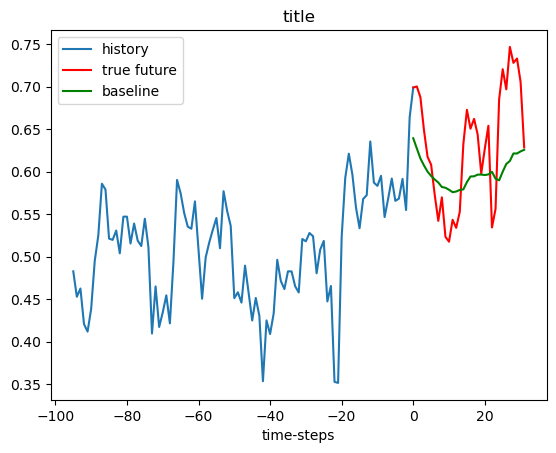

56 95
Epoch: 0056 train loss : 0.0118 time: 13.29877519607544


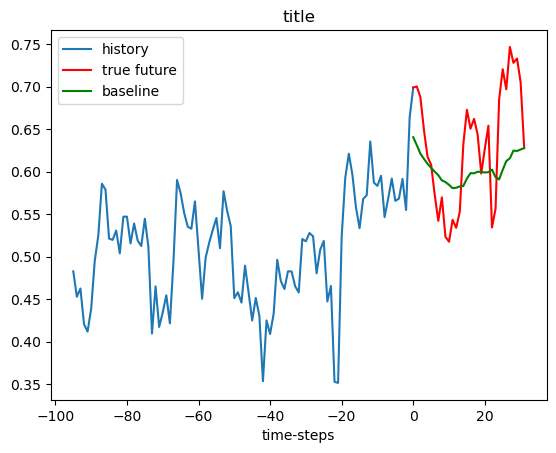

57 95
Epoch: 0057 train loss : 0.0117 time: 13.264827728271484


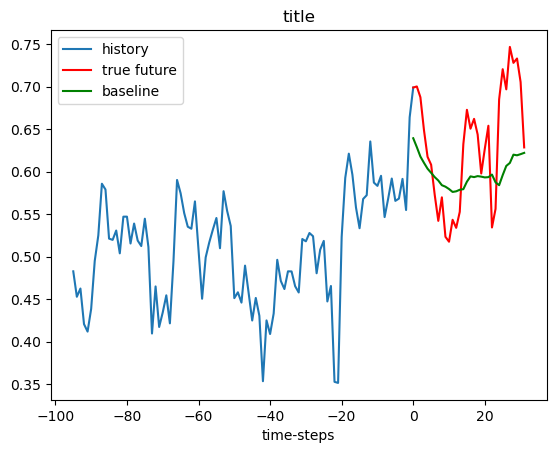

58 95
Epoch: 0058 train loss : 0.0116 time: 13.4854896068573


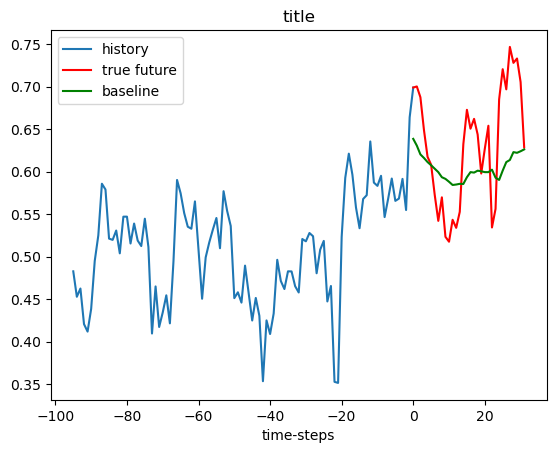

59 95
Epoch: 0059 train loss : 0.0116 time: 13.067918539047241


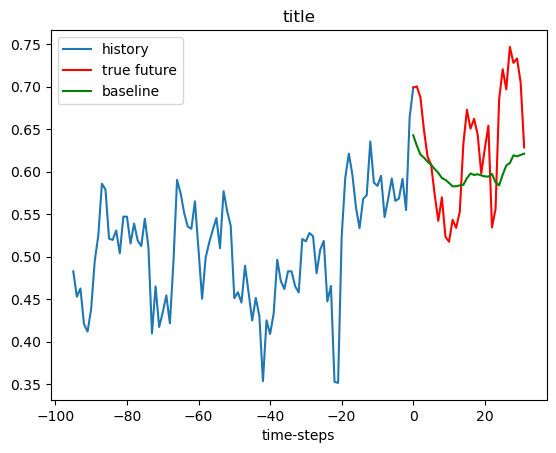

60 95
Epoch: 0060 train loss : 0.0115 time: 13.488269805908203


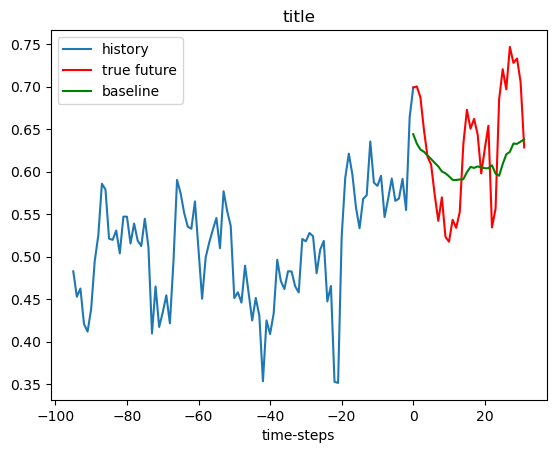

61 95
Epoch: 0061 train loss : 0.0117 time: 13.100508213043213


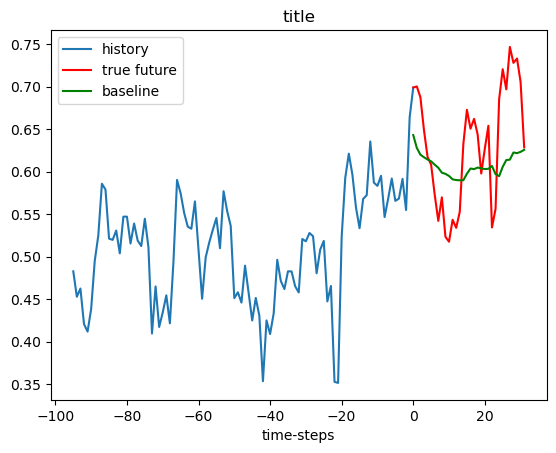

62 95
Epoch: 0062 train loss : 0.0118 time: 14.156373500823975


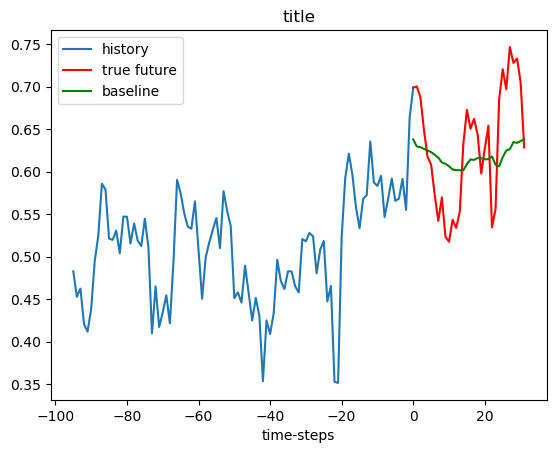

63 95
Epoch: 0063 train loss : 0.0118 time: 15.79922890663147


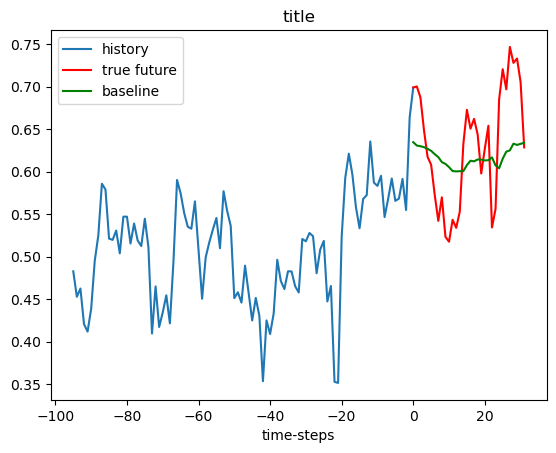

64 95
Epoch: 0064 train loss : 0.0118 time: 15.52064323425293


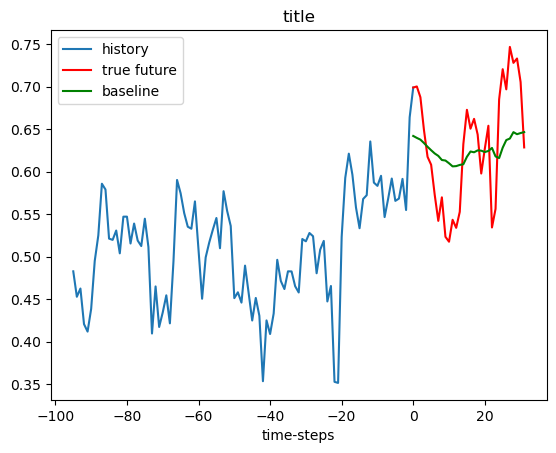

65 95
Epoch: 0065 train loss : 0.0120 time: 13.118591785430908


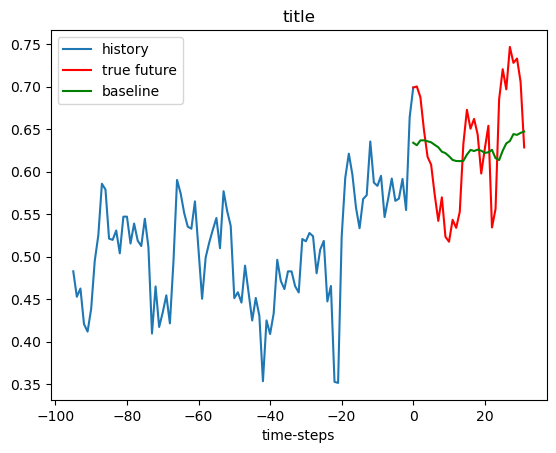

66 95
Epoch: 0066 train loss : 0.0118 time: 13.281645774841309


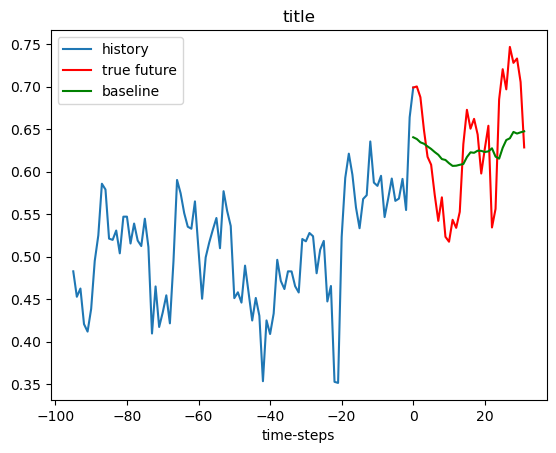

67 95
Epoch: 0067 train loss : 0.0118 time: 13.392529726028442


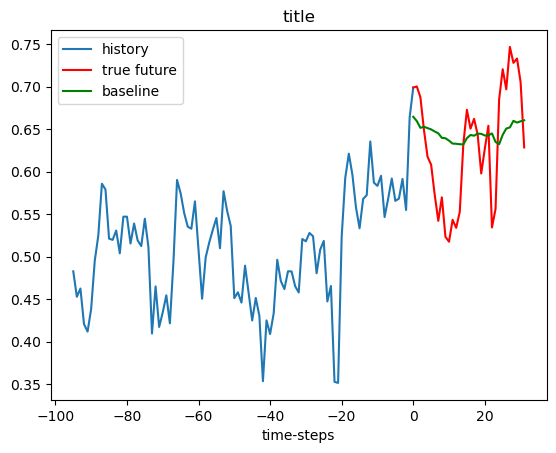

68 95
Epoch: 0068 train loss : 0.0118 time: 13.302520751953125


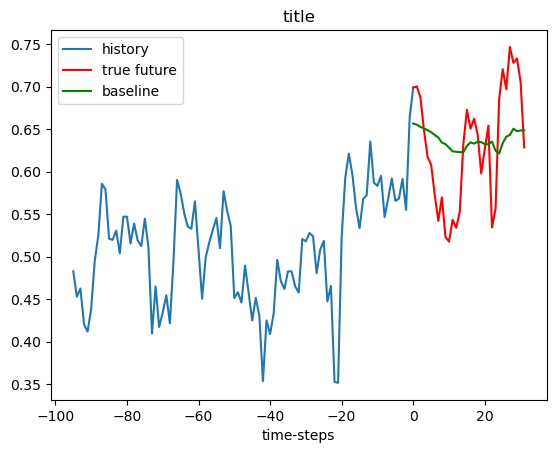

69 95
Epoch: 0069 train loss : 0.0118 time: 13.197529792785645


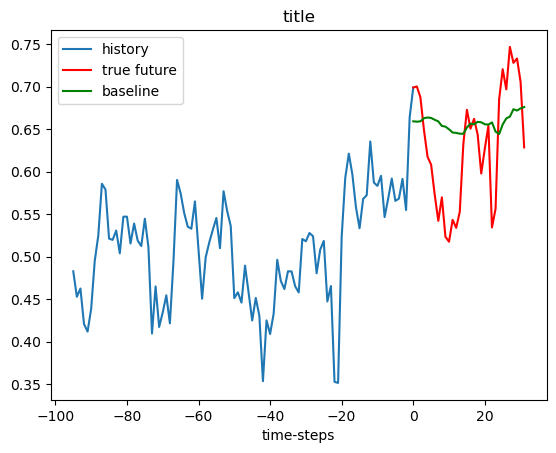

70 95
Epoch: 0070 train loss : 0.0119 time: 13.530648231506348


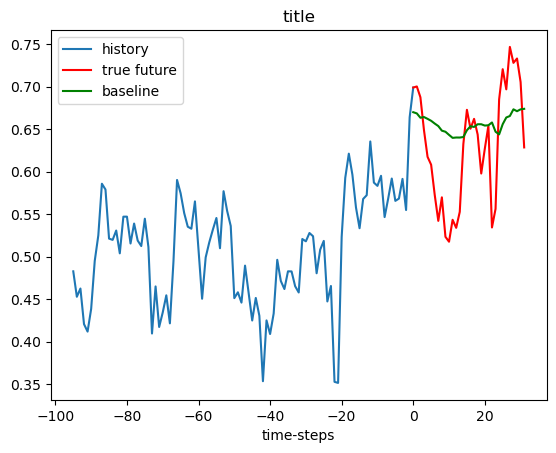


 Early Stopping


In [12]:
# train(x_train_uni., y_train_uni., model, criterion, optimizer, n_epoch)
model, train_hist = train_model(model2, dataloader, num_epochs = n_epoch, lr = lr, verbose = 1, patience = 10)

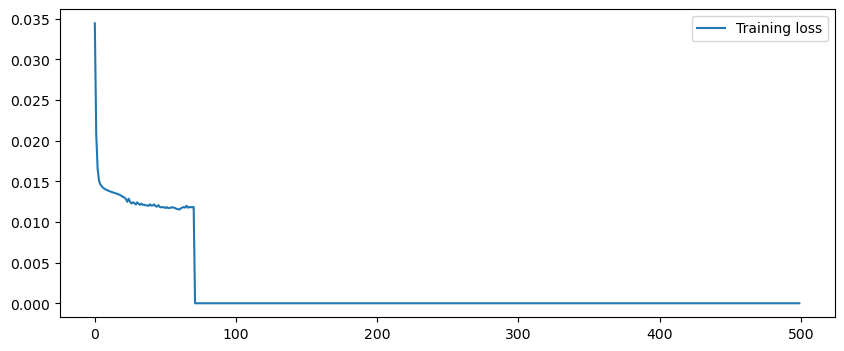

In [13]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [14]:
# 모델 저장    
#PATH = "./mywork/checkpoint/Timeseries_LSTM_data_w_RevIN.pth"
PATH = "./mywork/checkpoint/Timeseries_LSTM_data_wo_RevIN.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
# model1 = LSTM(input_size=1, hidden_size=hidden_size, n_layers=n_layers, num_classes=1)
model = MY_LSTM(input_size=history_size, predict_size=predict_size, hidden_size=hidden_size, n_layers=n_layers, use_RevIN=True).to(device)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

MY_LSTM(
  (cells): ModuleList(
    (0): LSTMCell(
      (hidden_lin): Linear(in_features=256, out_features=1024, bias=True)
      (input_lin): Linear(in_features=96, out_features=1024, bias=False)
    )
    (1-3): 3 x LSTMCell(
      (hidden_lin): Linear(in_features=256, out_features=1024, bias=True)
      (input_lin): Linear(in_features=256, out_features=1024, bias=False)
    )
  )
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (revin): RevIN()
)

In [15]:
def RSE(pred, true):
    return np.sqrt(np.sum((true-pred)**2)) / np.sqrt(np.sum((true-true.mean())**2))

def CORR(pred, true):
    u = ((true-true.mean(0))*(pred-pred.mean(0))).sum(0) 
    d = np.sqrt(((true-true.mean(0))**2*(pred-pred.mean(0))**2).sum(0))
    return (u/d).mean(-1)

def MAE(pred, true):
    return np.mean(np.abs(pred-true))

def MSE(pred, true):
    return np.mean((pred-true)**2)

def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))

def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rse = RSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    print('MAE SCORE : ', mae)
    print('MSE SCORE : ', mse)
    print('RSE SCORE : ', rse)
    print('RMSE SCORE : ', rmse)
    print('MAPE SCORE : ', mape)
    print('MSPE SCORE : ', mspe)

# 예측 테스트
with torch.no_grad(): 
    pred = []
    true = []
    for pr in test_dataloader:
        test_x, test_y = pr
        if test_x.shape[0] < 64:
            continue
        predicted, _ = model(test_x.squeeze(0))
        pred.append(predicted[:, -1, :].squeeze(-1).cpu())
        true.append(test_y.cpu())
        
        
    true = np.array(true)
    pred = np.array(pred)
    metric(pred, true)

MAE SCORE :  0.09405374
MSE SCORE :  0.016325286
RSE SCORE :  0.96923566
RMSE SCORE :  0.12777044
MAPE SCORE :  0.17194225
MSPE SCORE :  0.09002185
